# Model Training Using Inputs (Pre-Processed Dataset and Labels CSV)

In [175]:
import numpy as np
import pandas as pd

X_train = pd.read_csv("trainset.csv", index_col=0)
X_test = pd.read_csv("testset.csv", index_col=0)
X_val = pd.read_csv("valset.csv", index_col=0)

y_train = X_train.label
y_test = X_test.label
y_val = X_val.label

X_train = X_train.drop(columns=["label"])
X_test = X_test.drop(columns=["label"])
X_val = X_val.drop(columns=["label"])

## Perform RFECV

Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 41 features.
Fitting estimator with 41 fe

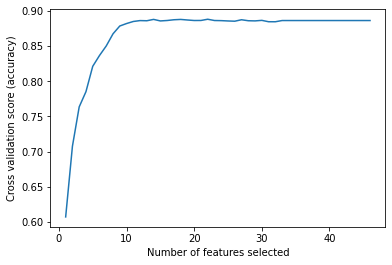

Num Features Before: 46
Num Features After: 22


In [42]:
import xgboost as xgb
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import math

min_features_to_select = 1

# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts().values[0]/y_train.value_counts().values[1])

# create a random forest model
clf_xgb = xgb.XGBClassifier(random_state=4262, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight)

# Recursively eliminate features with cross validation
rfecv = RFECV(estimator=clf_xgb, cv=5, scoring='roc_auc', n_jobs=-1, verbose=10, step=1, min_features_to_select= min_features_to_select)
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (accuracy)")
plt.plot(
    range(min_features_to_select, len(rfecv.grid_scores_) + min_features_to_select),
    rfecv.grid_scores_,
)
plt.show()

X_new = rfecv.transform(X_train)
print("Num Features Before:", X_train.shape[1])
print("Num Features After:", X_new.shape[1])

## Features Chosen from RFECV

In [43]:
rfecv.support_

array([False,  True,  True,  True,  True,  True, False, False,  True,
        True,  True,  True,  True,  True, False, False,  True, False,
       False, False,  True,  True, False,  True, False,  True, False,
       False, False, False, False, False, False, False, False, False,
       False,  True, False, False,  True,  True,  True,  True, False,
        True])

## Hyperparameter Tuning with RandomizedSearchCV/GridSearchCV

In [178]:
X_train = X_train.iloc[:, rfecv.support_]

In [45]:
X_train.columns

Index(['sd_-1', 'mean_-1', 'dwell_time_0', 'sd_0', 'mean_0', 'mean_1',
       'avg_hash_1_mer', 'avg_hash_2_mer', 'avg_hash_3_mer', 'avg_hash_4_mer',
       'avg_hash_5_mer', 'PWM', 'T_1', 'A_2', 'G_2', 'A_3', 'A_6', 'T_6',
       'A_7', 'C_7', 'G_7', 'GGACT_Present'],
      dtype='object')

In [71]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import math

# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts()[0]/y_train.value_counts()[1])

clf = xgb.XGBClassifier(random_state=4262, colsample_bytree = 0.8, colsample_bynode = 0.8, colsample_bylevel = 0.8, use_label_encoder = False,
                        eval_metric = "logloss", objective = "binary:logistic", scale_pos_weight = scale_pos_weight, n_estimators = 200)

params = {
 "learning_rate" : [0.03, 0.05, 0.08],
 "max_depth" : [5, 7, 10],
 "min_child_weight" : [1, 3, 5],
 "gamma": [0.5, 1],
 "alpha": [0, 0.5],
 "subsample": [0.8, 1],
 "n_estimators":[300, 500, 700]
}

# rscv_model = RandomizedSearchCV(clf, param_distributions=params, n_iter=10, scoring='average_precision', n_jobs=-1, cv=5, verbose=10)
gscv_model = GridSearchCV(clf, param_grid = params, verbose =10, cv=5, scoring = 'average_precision', n_jobs=-1)

In [70]:
from hypopt import GridSearch

# To account for weight imbalances
scale_pos_weight = math.sqrt(y_train.value_counts()[0]/y_train.value_counts()[1])

clf = xgb.XGBClassifier(random_state=4262, colsample_bytree = 0.8, colsample_bynode = 0.8, colsample_bylevel = 0.8, use_label_encoder = False,
                        eval_metric = "aucpr", objective = "binary:logistic", scale_pos_weight = scale_pos_weight)

params = {
 "learning_rate" : [0.03, 0.05, 0.08],
 "max_depth" : [5, 7, 10],
 "min_child_weight" : [1, 3, 5],
 "gamma": [0.5, 1],
 "alpha": [0.5],
 "subsample": [0.8, 1],
 "n_estimators":[300, 500, 700]
}

# Grid-search all parameter combinations using a validation set.
gs = GridSearch(model = clf, param_grid = params, parallelize=False)
gs.fit(X_train, y_train, X_val, y_val, scoring="average_precision")
print('Test Score for Optimized Parameters:', gs.score(X_test, y_test))

KeyboardInterrupt: 

In [72]:
# Uncomment if you want to run the gridsearch
# rscv_model.fit(X_train, y_train)
gscv_model.fit(X_train, y_train)

Fitting 5 folds for each of 648 candidates, totalling 3240 fits
[CV 2/5; 1/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8
[CV 3/5; 1/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8
[CV 2/5; 2/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1
[CV 3/5; 2/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1
[CV 1/5; 1/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8
[CV 1/5; 2/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, subsample=1
[CV 5/5; 1/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=5, min_child_weight=1, n_estimators=300, subsample=0.8
[CV 4/5; 1/648] START alpha=0, gamma=0.5, learning_ra

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 3/5; 40/648] END alpha=0, gamma=0.5, learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1;, score=0.478 total time= 2.9min
[CV 5/5; 41/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=700, subsample=0.8
[CV 1/5; 42/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=700, subsample=1
[CV 5/5; 40/648] END alpha=0, gamma=0.5, learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1;, score=0.445 total time= 2.9min
[CV 4/5; 40/648] END alpha=0, gamma=0.5, learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=500, subsample=1;, score=0.465 total time= 2.9min
[CV 2/5; 42/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=700, subsample=1
[CV 3/5; 42/648] START alpha=0, gamma=0.5, learning_rate=0.03, max_depth=10, min_child_weight=1, n_estimators=700, subsample=1
[CV 2/5; 41/648]

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=0.8,
                                     colsample_bynode=0.8, colsample_bytree=0.8,
                                     eval_metric='logloss', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_es...
                                     scale_pos_weight=4.526171050384845,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=False,
                                     validate_parameters=None, verbosity=None

In [74]:
gscv_model.best_estimator_
# rscv_model.best_estimator_

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.8, colsample_bytree=0.8, eval_metric='logloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.03, max_delta_step=0,
              max_depth=7, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=4262, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=4.526171050384845, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [75]:
gscv_model.best_score_

0.45392034382662627

In [176]:
X_val = X_val.iloc[:, rfecv.support_]

In [179]:
clf_xgb = xgb.XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.8, colsample_bytree=0.8, eval_metric='logloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=7, min_child_weight=3,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=4262, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=4.526171050384845, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)
clf_xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], eval_metric = "aucpr", verbose=True, early_stopping_rounds=20)

[0]	validation_0-aucpr:0.29059
[1]	validation_0-aucpr:0.29985
[2]	validation_0-aucpr:0.32348
[3]	validation_0-aucpr:0.34721
[4]	validation_0-aucpr:0.34990
[5]	validation_0-aucpr:0.35570
[6]	validation_0-aucpr:0.35347
[7]	validation_0-aucpr:0.34883
[8]	validation_0-aucpr:0.35059
[9]	validation_0-aucpr:0.35087
[10]	validation_0-aucpr:0.34798
[11]	validation_0-aucpr:0.34799
[12]	validation_0-aucpr:0.34904
[13]	validation_0-aucpr:0.35069
[14]	validation_0-aucpr:0.35330
[15]	validation_0-aucpr:0.35670
[16]	validation_0-aucpr:0.35611
[17]	validation_0-aucpr:0.36057
[18]	validation_0-aucpr:0.36249
[19]	validation_0-aucpr:0.36222
[20]	validation_0-aucpr:0.35947
[21]	validation_0-aucpr:0.36083
[22]	validation_0-aucpr:0.36033
[23]	validation_0-aucpr:0.36180
[24]	validation_0-aucpr:0.36394
[25]	validation_0-aucpr:0.36653
[26]	validation_0-aucpr:0.36744
[27]	validation_0-aucpr:0.36774
[28]	validation_0-aucpr:0.36969
[29]	validation_0-aucpr:0.36925
[30]	validation_0-aucpr:0.37303
[31]	validation_0-

XGBClassifier(alpha=0, base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=0.8, colsample_bytree=0.8, eval_metric='logloss',
              gamma=0.5, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.05, max_delta_step=0,
              max_depth=7, min_child_weight=3, missing=nan,
              monotone_constraints='()', n_estimators=500, n_jobs=8,
              num_parallel_tree=1, random_state=4262, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=4.526171050384845, subsample=0.8,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

In [148]:
X_test.iloc[:, rfecv.support_]

,sd_-1,mean_-1,dwell_time_0,sd_0,mean_0,mean_1,avg_hash_1_mer,avg_hash_2_mer,avg_hash_3_mer,avg_hash_4_mer,...,T_1,A_2,G_2,A_3,A_6,T_6,A_7,C_7,G_7,GGACT_Present
97483,1.771679,90.912500,0.006675,2.451071,96.007143,88.698214,1.021002e+09,2.024846e+09,1.659494e+09,1.452650e+09,...,1,0,0,1,1,0,0,0,0,0
97484,2.228750,104.394231,0.008992,3.109231,105.186538,94.971154,1.531001e+09,1.656882e+09,8.789353e+08,9.300901e+08,...,1,1,0,1,0,1,0,0,1,0
97485,2.558725,88.090196,0.005919,3.134510,94.594118,82.478431,2.041001e+09,2.079875e+09,2.110127e+09,1.335660e+09,...,0,0,0,1,0,0,1,0,0,0
97486,2.733273,104.049091,0.008983,4.330000,97.898182,80.067273,2.041001e+09,2.004578e+09,1.752460e+09,9.116598e+08,...,0,1,0,1,0,0,1,0,0,0
97487,5.043000,110.800000,0.010036,7.399400,124.840000,77.220000,2.551000e+09,1.736187e+09,1.430192e+09,1.570155e+09,...,0,1,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
109674,4.404314,118.568627,0.009180,8.374706,118.588235,79.570588,3.061000e+09,1.513158e+09,1.822430e+09,1.244292e+09,...,1,0,1,0,0,0,0,1,0,0
109675,5.394630,119.296296,0.008939,5.407778,124.592593,90.792593,2.551000e+09,1.238538e+09,1.233700e+09,1.477232e+09,...,0,0,1,0,0,1,0,1,0,1
109676,4.643907,115.209302,0.009336,7.675116,115.302326,80.211628,3.061000e+09,1.453287e+09,1.294931e+09,1.758305e+09,...,0,0,1,0,1,0,0,0,1,0
109677,4.429821,117.285714,0.007600,7.358214,119.214286,79.167857,3.061000e+09,1.110517e+09,1.315406e+09,1.448923e+09,...,0,0,1,0,0,0,0,0,0,0


In [186]:
X_test = X_test.iloc[:, rfecv.support_]

In [173]:
from sklearn.metrics import average_precision_score, roc_auc_score, accuracy_score

y_pred = clf_xgb.predict(X_test)
y_pred_proba = clf_xgb.predict_proba(X_test)
auc_score = roc_auc_score(y_test, y_pred_proba[:,1])
ap = average_precision_score(y_test, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_test, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9533453591341423
AUC-ROC: 0.8850774739922165
PR-ROC: 0.4185486564588502


## Generating Files For Submission

### Reading Dataset1 and Dataset2

In [129]:
ds1 = pd.read_csv("ds1_df_ggact.csv", index_col=0)
ds2 = pd.read_csv("ds2_df_ggact.csv", index_col=0)

ds1_output = ds1.copy()[["transcript_id", "transcript_pos"]]
ds2_output = ds2.copy()[["transcript_id", "transcript_pos"]]

In [130]:
ds1.rename(columns={"nucleo_seq.1":"ggact_present"}, inplace=True)
ds2.rename(columns={"nucleo_seq.1":"ggact_present"}, inplace=True)

In [131]:
ds1.drop(columns=["nucleo_seq", "transcript_id", "transcript_pos"], inplace=True)
ds2.drop(columns=["nucleo_seq", "transcript_id", "transcript_pos"], inplace=True)

### Selecting features from RFECV

In [132]:
ds1 = ds1.iloc[:, rfecv.support_]
ds2 = ds2.iloc[:, rfecv.support_]

In [133]:
def output(dataset, model, df):
    
    # Get probabilities of 1
    score = pd.DataFrame(model.predict_proba(dataset)[:, 1], columns=["score"])
    output = pd.concat([df, score], axis=1)
    output.rename(columns={"transcript_pos":"transcript_position"}, inplace=True)
    return output

In [134]:
output(ds1, clf_xgb, ds1_output).to_csv("ds1_xgb_final_ggact.csv", index=False)
output(ds2, clf_xgb, ds2_output).to_csv("ds2_xgb_final_ggact.csv", index=False)

In [150]:
output(ds1, clf_xgb, ds1_output)

,transcript_id,transcript_position,score
0,ENST00000000233,244,0.032246
1,ENST00000000233,261,0.039323
2,ENST00000000233,316,0.029667
3,ENST00000000233,332,0.086431
4,ENST00000000233,368,0.100045
...,...,...,...
90805,ENST00000641784,3122,0.157697
90806,ENST00000641784,3142,0.074719
90807,ENST00000641784,3224,0.714035
90808,ENST00000641784,3243,0.083037


In [152]:
output(ds2, clf_xgb, ds2_output)

,transcript_id,transcript_position,score
0,AT1G01050.1,155,0.022782
1,AT1G01050.1,165,0.003130
2,AT1G01050.1,347,0.070919
3,AT1G01050.1,435,0.017999
4,AT1G01050.2,463,0.016784
...,...,...,...
98825,AT5G67590.1,367,0.014028
98826,AT5G67590.1,444,0.037298
98827,AT5G67590.1,465,0.107826
98828,AT5G67590.1,663,0.023432


In [155]:
X_val

,dwell_time_-1,sd_-1,mean_-1,dwell_time_0,sd_0,mean_0,dwell_time_1,sd_1,mean_1,avg_hash_1_mer,...,T_5,A_6,C_6,G_6,T_6,A_7,C_7,G_7,T_7,GGACT_Present
109679,0.005883,1.574561,92.001220,0.007397,2.186171,100.356098,0.005525,1.775122,94.471951,1.021002e+09,...,0,0,0,0,1,0,0,0,1,0
109680,0.007630,4.816538,102.753846,0.006866,6.632308,124.807692,0.007869,3.180000,91.030769,2.551000e+09,...,0,0,0,0,1,0,0,1,0,0
109681,0.006674,4.262083,120.000000,0.006405,7.510000,118.291667,0.005922,3.856250,82.079167,3.061000e+09,...,0,1,0,0,0,0,1,0,0,0
109682,0.006914,3.731111,97.259259,0.006823,9.160000,112.481481,0.005413,3.153704,83.970370,1.531001e+09,...,0,1,0,0,0,0,0,0,1,0
109683,0.006579,3.738667,121.200000,0.009034,4.474667,129.600000,0.007655,3.122667,82.637778,2.041001e+09,...,0,0,1,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121833,0.007765,2.834000,86.765000,0.007522,3.192500,93.075000,0.005923,2.020500,80.110000,1.531001e+09,...,0,0,1,0,0,1,0,0,0,0
121834,0.007456,2.078095,86.904762,0.006193,1.912857,93.680952,0.007296,2.306667,88.176190,1.021002e+09,...,0,1,0,0,0,1,0,0,0,0
121835,0.009868,1.972857,102.495238,0.007332,2.551905,97.928571,0.006917,2.198571,89.385714,1.021002e+09,...,0,1,0,0,0,1,0,0,0,0
121836,0.007247,2.359500,86.795000,0.011178,2.496500,97.965000,0.008500,1.588750,92.330000,1.531001e+09,...,0,0,0,0,1,0,1,0,0,0


In [180]:
data = pd.read_csv("data.csv", index_col=0)
info = pd.read_csv("data.info")

In [181]:
data['transcript_pos'] = data.transcript_pos.astype(int)
new_df = pd.merge(data, info, left_on=['transcript_id','transcript_pos'],right_on=['transcript_id','transcript_position'], how = 'left')
new_df = new_df.sort_values(by=['gene_id'], ascending=False).reset_index(drop=True)

In [195]:
ds0_output = new_df[["transcript_id", "transcript_pos"]]
ds0 = X_train.append(X_test).append(X_val)


In [196]:
output(ds0, clf_xgb, ds0_output).to_csv("ds0_xgb_final_ggact.csv", index=False)

In [197]:
score = pd.DataFrame(clf_xgb.predict_proba(ds0)[:, 1], columns=["score"])

In [198]:
score

,score
0,0.027483
1,0.005571
2,0.011864
3,0.029382
4,0.056107
...,...
121833,0.004876
121834,0.002751
121835,0.007380
121836,0.024947


In [199]:
y_label = y_train.append(y_test).append(y_val)

In [200]:
y_label

0         0
1         0
2         0
3         0
4         0
         ..
121833    0
121834    0
121835    0
121836    0
121837    0
Name: label, Length: 121838, dtype: int64

In [207]:
y_pred = clf_xgb.predict(ds0)
y_pred_proba = clf_xgb.predict_proba(ds0)
auc_score = roc_auc_score(y_label, y_pred_proba[:,1])
ap = average_precision_score(y_label, y_pred_proba[:,1])

print("Accuracy:", accuracy_score(y_label, y_pred))
print("AUC-ROC:", auc_score)
print("PR-ROC:", ap)

Accuracy: 0.9567786733203105
AUC-ROC: 0.9420937785736392
PR-ROC: 0.5381091133862784
